In [2]:
# Sleep Definitions, Rules, and Constraints for the Kaggle Sleep Detection Competition

# Goal:
# - Detect two types of events: sleep onset (beginning of sleep) and wake-up (end of sleep) from accelerometer data.

# Sleep Definition:
# - Sleep is referred to as the longest single period of inactivity while the accelerometer is being worn.

# Important Guidelines:
# - A single sleep period must be at least 30 minutes in length.
# - A sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes.
# - Only the longest sleep window is recorded per night.
# - No sleep windows can be detected unless the watch is deemed to be worn for the duration.
# - If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.
# - Sleep events do not need to straddle the day-line, and there's no hard rule defining how many may occur within a given period.
# - However, no more than one window should be assigned per night.
# - For example, it's valid to have a sleep window from 01:00–06:00 and 19:00–23:30 in the same calendar day, though assigned to consecutive nights.

# Data Handling Guidelines:
# - There might be periods within a series where the accelerometer device was removed, these periods should be ignored as they will be scored as false positives.

In [3]:
import pandas as pd

# Load the training data
train_series = pd.read_parquet('../data/train_series_datecorrected.parquet')
# Load the training events data
train_events = pd.read_csv('../data/train_events.csv')
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], format='%Y-%m-%dT%H:%M:%S%z')

# Load the test series data
test_series = pd.read_parquet('../data/test_series.parquet')

# perform comprehensive EDA on the data, by using f-strings to print out many different statistics
# Display the first few rows of each dataset to understand their structure
print(f"Training Series: {train_series.shape}")
print(train_series.head())
print(f"Test Series: {test_series.shape}")
print(test_series.head())
print(f"Training Events: {train_events.shape}")
print(train_events.head())

# print the type of each column
print(train_series.dtypes)
print(test_series.dtypes)
print(train_events.dtypes)


Training Series: (127946340, 6)
      series_id  step           timestamp  anglez    enmo timezone
0  038441c925bb     0 2018-08-14 15:30:00  2.6367  0.0217    -0400
1  038441c925bb     1 2018-08-14 15:30:05  2.6368  0.0215    -0400
2  038441c925bb     2 2018-08-14 15:30:10  2.6370  0.0216    -0400
3  038441c925bb     3 2018-08-14 15:30:15  2.6368  0.0213    -0400
4  038441c925bb     4 2018-08-14 15:30:20  2.6368  0.0215    -0400
Test Series: (450, 5)
      series_id  step                 timestamp  anglez    enmo
0  038441c925bb     0  2018-08-14T15:30:00-0400  2.6367  0.0217
1  038441c925bb     1  2018-08-14T15:30:05-0400  2.6368  0.0215
2  038441c925bb     2  2018-08-14T15:30:10-0400  2.6370  0.0216
3  038441c925bb     3  2018-08-14T15:30:15-0400  2.6368  0.0213
4  038441c925bb     4  2018-08-14T15:30:20-0400  2.6368  0.0215
Training Events: (14508, 5)
      series_id  night   event     step                  timestamp
0  038441c925bb      1   onset   4992.0  2018-08-14 22:26:00-04:0

C:\Users\dekel\AppData\Local\Temp\ipykernel_18072\210116582.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], format='%Y-%m-%dT%H:%M:%S%z')


In [ ]:
# Display the number of unique series_id's in each dataset
print(f"Training Series: {train_series.series_id.nunique()}")
print(f"Test Series: {test_series.series_id.nunique()}")
print(f"Training Events: {train_events.series_id.nunique()}")


Training Series: 277
Test Series: 3
Training Events: 277


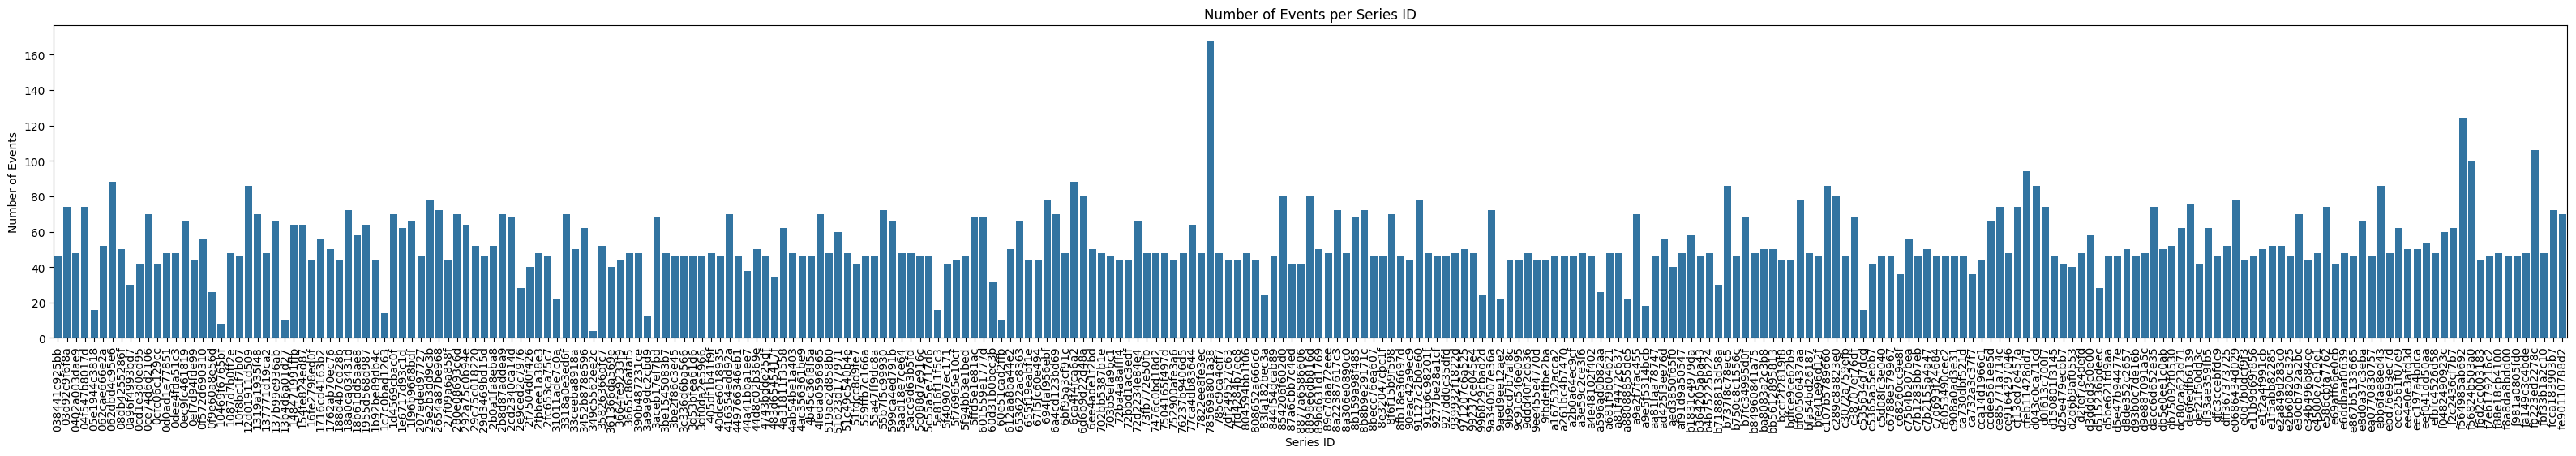

In [ ]:
# visualize the distribution of the number of events per series_id
import matplotlib.pyplot as plt
import seaborn as sns

# sort the events by series_id
event_counts = train_events.groupby('series_id').size().reset_index(name='count')
sorted_train_events = event_counts.sort_values(by='series_id')

# plot the number of events per series_id
plt.figure(figsize=(40, 5))
sns.barplot(data=sorted_train_events, x='series_id', y='count')
plt.title('Number of Events per Series ID')
plt.xlabel('Series ID')
plt.ylabel('Number of Events')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Merging the train_series with train_events on series_id and step
merged_data = pd.merge(train_series, train_events, on=['series_id', 'step'])
print(f"merged_data.head():\n {merged_data.head()}")
# this creates a timestamp_x and _y columns, and we want _x


merged_data.head() =       series_id   step         timestamp_x     anglez    enmo timezone  night  \
0  038441c925bb   4992 2018-08-14 22:26:00 -78.690598  0.0099    -0400      1   
1  038441c925bb  10932 2018-08-15 06:41:00 -61.578201  0.0263    -0400      1   
2  038441c925bb  20244 2018-08-15 19:37:00  -6.387400  0.0182    -0400      2   
3  038441c925bb  27492 2018-08-16 05:41:00 -45.355099  0.0165    -0400      2   
4  038441c925bb  39996 2018-08-16 23:03:00  -1.786700  0.0000    -0400      3   

    event                timestamp_y  
0   onset  2018-08-14 22:26:00-04:00  
1  wakeup  2018-08-15 06:41:00-04:00  
2   onset  2018-08-15 19:37:00-04:00  
3  wakeup  2018-08-16 05:41:00-04:00  
4   onset  2018-08-16 23:03:00-04:00  


In [ ]:
# Pre-compute onset and wakeup times
onset_times = merged_data[merged_data['event'] == 'onset'].set_index(['series_id', 'night'])['timestamp_x']
wakeup_times = merged_data[merged_data['event'] == 'wakeup'].set_index(['series_id', 'night'])['timestamp_x']

# Initialize lists to store mean values
mean_anglez_sleep, mean_enmo_sleep = [], []
mean_anglez_wake, mean_enmo_wake = [], []

for (series_id, night), group in merged_data.groupby(['series_id', 'night']):
    
    try:
        # Sleep session
        onset_time = onset_times.loc[series_id, night]
        wakeup_time = wakeup_times.loc[series_id, night]
        
        if onset_time is not None and wakeup_time is not None:
            sleep_data = group[
                (group['timestamp_x'] >= onset_time) &
                (group['timestamp_x'] <= wakeup_time)
            ]
            mean_anglez_sleep.append(sleep_data['anglez'].mean())
            mean_enmo_sleep.append(sleep_data['enmo'].mean())

        # Wake session - compare with the next night's onset
        next_onset_time = onset_times.loc[series_id, night + 1]
        wake_data = merged_data[
            (merged_data['series_id'] == series_id) &
            (merged_data['timestamp_x'] >= wakeup_time) &
            (merged_data['timestamp_x'] <= next_onset_time)
        ]
        mean_anglez_wake.append(wake_data['anglez'].mean())
        mean_enmo_wake.append(wake_data['enmo'].mean())
    except KeyError:
        print(f"The combination series {series_id} night {night + 1} doesn't exist")
        continue
    except Exception as e:
        raise e

#TODO: add series_id and night to each entry, so that the dataframes are comparable
# Create dataframes to store the mean values
df_sleep = pd.DataFrame({
    'Mean_AngleZ_Sleep': mean_anglez_sleep,
    'Mean_ENMO_Sleep': mean_enmo_sleep
})
df_wake = pd.DataFrame({
    'Mean_AngleZ_Wake': mean_anglez_wake,
    'Mean_ENMO_Wake': mean_enmo_wake
})
print(f"df_sleep: {df_sleep.shape}")
print(f"df_sleep: {df_sleep.head()}")
print(f"df_wake: {df_wake.shape}")
print(f"df_wake: {df_wake.head()}")

NameError: name 'merged_data' is not defined

In [ ]:

# Plotting
def plot_with_dual_axes(df, title):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Assume first column is for the primary y-axis
    color1 = 'blue'
    ax1.set_ylabel(df.columns[0], color=color1)
    sns.boxplot(data=df.iloc[:, [0]], ax=ax1, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    # Second column is for the secondary y-axis
    ax2 = ax1.twinx()
    color2 = 'green'
    ax2.set_ylabel(df.columns[1], color=color2)
    sns.boxplot(data=df.iloc[:, [1]], ax=ax2, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # Set plot title and show the plot
    plt.title(title)
    plt.show()

# Call this function for your dataframes
plot_with_dual_axes(df_sleep, 'Box Plot of Mean Angle Z and ENMO During Sleep Sessions')
plot_with_dual_axes(df_wake, 'Box Plot of Mean Angle Z and ENMO During Wake Sessions')


# Combined plot function
import matplotlib.pyplot as plt
import seaborn as sns

def combined_dual_axis_plot(df1, df2, title):
    _, ax1 = plt.subplots(figsize=(10, 5))

    # Plotting anglez data
    sns.boxplot(data=[df1['Mean_AngleZ_Sleep'], df2['Mean_AngleZ_Wake']], ax=ax1, palette=['blue', 'lightblue'])
    ax1.set_ylabel('AngleZ', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(['Sleep AngleZ', 'Wake AngleZ'], loc='upper left')

    # Creating a secondary y-axis for enmo data
    ax2 = ax1.twinx()
    sns.boxplot(data=[df1['Mean_ENMO_Sleep'], df2['Mean_ENMO_Wake']], ax=ax2, palette=['red', 'pink'])
    ax2.set_ylabel('ENMO', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(['Sleep ENMO', 'Wake ENMO'], loc='upper right')

    # Set plot title and show the plot
    plt.title(title)
    plt.show()

# Call this function with your dataframes
combined_dual_axis_plot(df_sleep, df_wake, 'Combined Box Plot for Sleep and Wake Sessions')


#TODO add difference plot (notic the different lengths of the two dataframes)
#TODO add summary statistics on the plots


